## Task 1 - Data exploration and preparation

### 1.1 Exploration

--- TRAIN SET ---
Set: train, Class: paper, Image shape: (300, 300, 3)


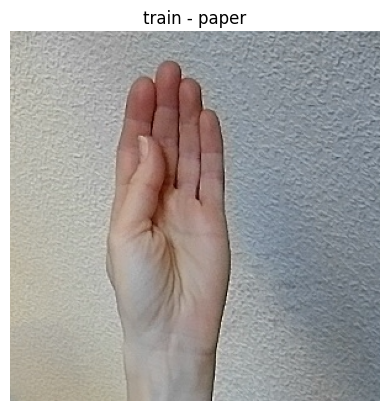

Set: train, Class: rock, Image shape: (300, 300, 3)


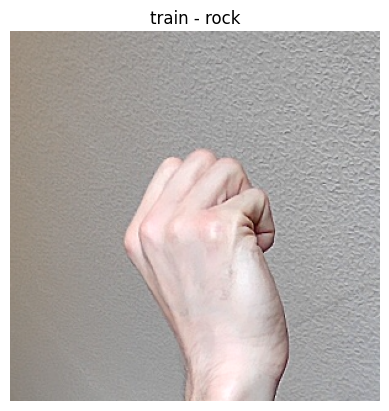

Set: train, Class: scissors, Image shape: (300, 300, 3)


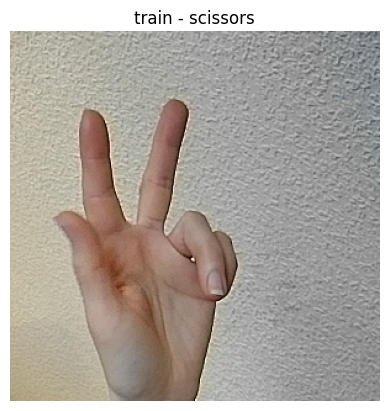

--- DEVTEST SET ---
Set: devtest, Class: rock, Image shape: (300, 300, 3)


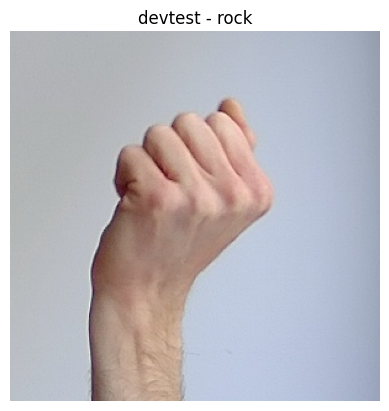

Set: devtest, Class: scissors, Image shape: (300, 300, 3)


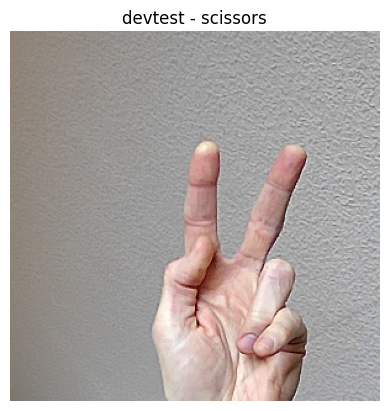

Set: devtest, Class: paper, Image shape: (300, 300, 3)


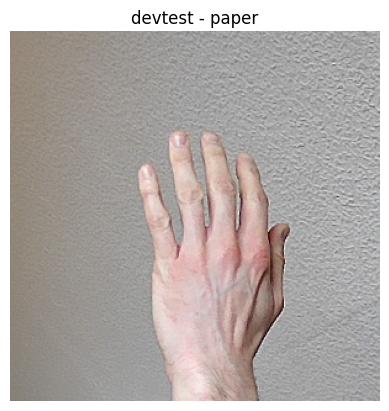

--- TEST SET ---
Set: test, Class: paper, Image shape: (300, 300, 3)


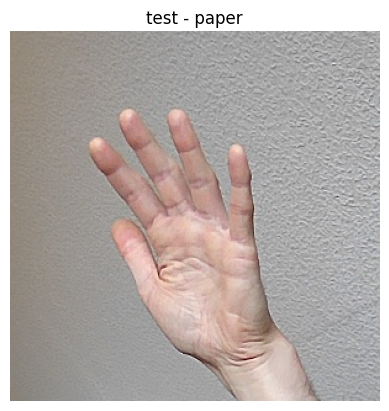

Set: test, Class: rock, Image shape: (300, 300, 3)


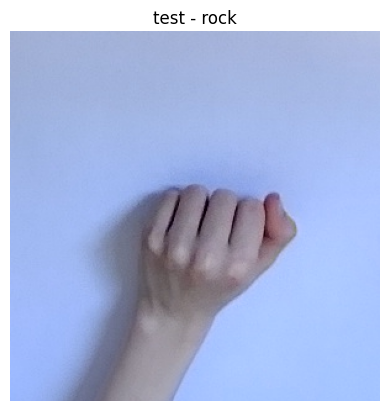

Set: test, Class: scissors, Image shape: (300, 300, 3)


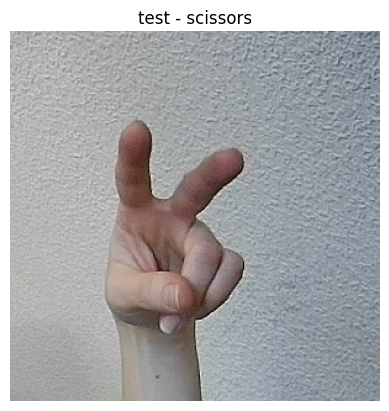


Class counts in TRAIN set:
  rock: 544
  paper: 544
  scissors: 541

Class counts in DEVTEST set:
  rock: 181
  paper: 181
  scissors: 180

Class counts in TEST set:
  rock: 182
  paper: 182
  scissors: 182


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from collections import Counter

# Load CSV files
train_df = pd.read_csv('train.csv')
devtest_df = pd.read_csv('devtest.csv')
test_df = pd.read_csv('test.csv')

# Function to display one image per class
def show_sample_images(df, set_name):
    print(f"--- {set_name.upper()} SET ---")
    shown_classes = set()
    for idx, row in df.iterrows():
        label = row['label']
        file_path = row['path']
        if label not in shown_classes:
            img = Image.open(file_path)
            img_array = np.array(img)
            print(f"Set: {set_name}, Class: {label}, Image shape: {img_array.shape}")
            plt.imshow(img)
            plt.title(f"{set_name} - {label}")
            plt.axis('off')
            plt.show()
            shown_classes.add(label)
        if len(shown_classes) == 3:
            break

# Show one image per class from each dataset
show_sample_images(train_df, 'train')
show_sample_images(devtest_df, 'devtest')
show_sample_images(test_df, 'test')

# Function to count images per class
def count_classes(df, set_name):
    counts = Counter(df['label'])
    print(f"\nClass counts in {set_name.upper()} set:")
    for cls in ['rock', 'paper', 'scissors']:
        print(f"  {cls}: {counts.get(cls, 0)}")

# Count class distribution in each set
count_classes(train_df, 'train')
count_classes(devtest_df, 'devtest')
count_classes(test_df, 'test')


### 1.2 Preparation

In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define image transformations: Resize + Normalize
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()  # Converts to tensor and scales to [0, 1]
])

# Custom Dataset class using CSV and image folders
class RockPaperScissorsDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['file']
        label = self.label_map[self.data.iloc[idx]['label']]
        image = Image.open(img_path).convert('RGB')  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to CSV files
train_csv = 'train.csv'
devtest_csv = 'devtest.csv'
test_csv = 'test.csv'

# Create datasets
train_dataset = RockPaperScissorsDataset(train_csv, transform=transform)
devtest_dataset = RockPaperScissorsDataset(devtest_csv, transform=transform)
test_dataset = RockPaperScissorsDataset(test_csv, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
devtest_loader = DataLoader(devtest_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
